In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
import torch 
import torch.nn as nn

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_chs)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_chs)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    
class resnet(nn.Module): # n layers of blocks, r classes 
    def __init__(self, resd_block, layers, img_chs, r):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2)
        # self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), nn.BatchNorm2d(out_chs))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

def final_resnet(img_chs, r, n):
    return resnet(resd_block, [n, n, n], img_chs, r)

In [3]:
# def test():
#     net = final_resnet(3, 25, 2)
#     x = torch.randn(2, 3, 256, 256)
#     y = net(x)
#     print(y.size())

# test()

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
Working on device:  cuda:0
------------------------Training Started------------------------


100%|██████████| 263/263 [00:17<00:00, 15.43it/s]


Epoch:  0 Train Loss:  0.09873298936208391 Train Accuracy:  7.468470612231023 Train F1 Macro:  0.04965635043628251 Train F1 Micro:  0.07468470612231023
Epoch:  0 Validation Loss:  0.09552242961916645 Validation Accuracy:  12.195411862593605 Validation F1 Macro:  0.0857737123760526 Validation F1 Micro:  0.12195411862593605
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.92it/s]


Epoch:  1 Train Loss:  0.09410242297313277 Train Accuracy:  13.152258897916171 Train F1 Macro:  0.10514836332378817 Train F1 Micro:  0.13152258897916172
Epoch:  1 Validation Loss:  0.09178104928312639 Validation Accuracy:  16.37941281350291 Validation F1 Macro:  0.13322323381869347 Validation F1 Micro:  0.1637941281350291
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.62it/s]


Epoch:  2 Train Loss:  0.09106832428833085 Train Accuracy:  16.36128769079104 Train F1 Macro:  0.13732641241680654 Train F1 Micro:  0.1636128769079104
Epoch:  2 Validation Loss:  0.08893595673617662 Validation Accuracy:  19.19648163556401 Validation F1 Macro:  0.1671596354530636 Validation F1 Micro:  0.19196481635564008
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.72it/s]


Epoch:  3 Train Loss:  0.08865892869690183 Train Accuracy:  18.183363361321685 Train F1 Macro:  0.15917334627598403 Train F1 Micro:  0.18183363361321686
Epoch:  3 Validation Loss:  0.08675074303857243 Validation Accuracy:  20.313800071318198 Validation F1 Macro:  0.17172988546359216 Validation F1 Micro:  0.203138000713182
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.77it/s]


Epoch:  4 Train Loss:  0.08665496562960746 Train Accuracy:  20.151613012883708 Train F1 Macro:  0.17637830491728232 Train F1 Micro:  0.20151613012883707
Epoch:  4 Validation Loss:  0.0861640069312691 Validation Accuracy:  21.2171639129918 Validation F1 Macro:  0.1890296312456389 Validation F1 Micro:  0.21217163912991802
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.59it/s]


Epoch:  5 Train Loss:  0.08487138262854178 Train Accuracy:  21.069449637964443 Train F1 Macro:  0.19033612737201416 Train F1 Micro:  0.21069449637964444
Epoch:  5 Validation Loss:  0.08471351410650292 Validation Accuracy:  22.429573279448473 Validation F1 Macro:  0.20327528805007092 Validation F1 Micro:  0.22429573279448473
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.74it/s]


Epoch:  6 Train Loss:  0.0833118939159007 Train Accuracy:  22.595777951524628 Train F1 Macro:  0.20634593178819377 Train F1 Micro:  0.22595777951524632
Epoch:  6 Validation Loss:  0.08889953212733503 Validation Accuracy:  18.16236776417449 Validation F1 Macro:  0.1392107052920547 Validation F1 Micro:  0.18162367764174495
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.60it/s]


Epoch:  7 Train Loss:  0.08188003396649135 Train Accuracy:  23.435428493728118 Train F1 Macro:  0.2162623982314428 Train F1 Micro:  0.23435428493728117
Epoch:  7 Validation Loss:  0.08047366238626588 Validation Accuracy:  24.022346368715084 Validation F1 Macro:  0.22377184556801233 Validation F1 Micro:  0.24022346368715083
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.70it/s]


Epoch:  8 Train Loss:  0.08065305018921812 Train Accuracy:  24.213889927592888 Train F1 Macro:  0.22627245549045508 Train F1 Micro:  0.24213889927592888
Epoch:  8 Validation Loss:  0.0813002474849578 Validation Accuracy:  23.808391774634494 Validation F1 Macro:  0.22128485076801507 Validation F1 Micro:  0.23808391774634496
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.55it/s]


Epoch:  9 Train Loss:  0.07937967032827324 Train Accuracy:  25.57364789067546 Train F1 Macro:  0.24129846948004233 Train F1 Micro:  0.2557364789067546
Epoch:  9 Validation Loss:  0.07762396638832378 Validation Accuracy:  26.946392487816475 Validation F1 Macro:  0.2559506278551782 Validation F1 Micro:  0.26946392487816473
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.86it/s]


Epoch:  10 Train Loss:  0.07816252930668374 Train Accuracy:  26.60366454771051 Train F1 Macro:  0.25224228171002244 Train F1 Micro:  0.2660366454771051
Epoch:  10 Validation Loss:  0.07693865401813141 Validation Accuracy:  27.37430167597765 Validation F1 Macro:  0.25940255005603446 Validation F1 Micro:  0.2737430167597765
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.58it/s]


Epoch:  11 Train Loss:  0.07801672577286584 Train Accuracy:  26.899411904680964 Train F1 Macro:  0.25480037083751117 Train F1 Micro:  0.26899411904680964
Epoch:  11 Validation Loss:  0.07667034255839068 Validation Accuracy:  28.64614287412338 Validation F1 Macro:  0.27250695975292705 Validation F1 Micro:  0.2864614287412338
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.74it/s]


Epoch:  12 Train Loss:  0.07781031525880276 Train Accuracy:  26.882414930142435 Train F1 Macro:  0.253917253482945 Train F1 Micro:  0.26882414930142434
Epoch:  12 Validation Loss:  0.0766840141479572 Validation Accuracy:  28.05182455723285 Validation F1 Macro:  0.26510428616796733 Validation F1 Micro:  0.2805182455723285
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.75it/s]


Epoch:  13 Train Loss:  0.07761938529703981 Train Accuracy:  26.930006458850325 Train F1 Macro:  0.25492035630909327 Train F1 Micro:  0.26930006458850325
Epoch:  13 Validation Loss:  0.07653240829929364 Validation Accuracy:  28.289551883989066 Validation F1 Macro:  0.26982013401371396 Validation F1 Micro:  0.28289551883989067
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.73it/s]


Epoch:  14 Train Loss:  0.07746357566361992 Train Accuracy:  27.28354352925179 Train F1 Macro:  0.2592893763601728 Train F1 Micro:  0.2728354352925179
Epoch:  14 Validation Loss:  0.07650989891302992 Validation Accuracy:  28.360870082015925 Validation F1 Macro:  0.2717334283387626 Validation F1 Micro:  0.28360870082015927
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.82it/s]


Epoch:  15 Train Loss:  0.07735308631659404 Train Accuracy:  27.320936873236562 Train F1 Macro:  0.25911651253502 Train F1 Micro:  0.2732093687323656
Epoch:  15 Validation Loss:  0.07642321828626558 Validation Accuracy:  28.91952929989302 Validation F1 Macro:  0.27386355094554804 Validation F1 Micro:  0.2891952929989302
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.64it/s]


Epoch:  16 Train Loss:  0.077155821335633 Train Accuracy:  27.37872658666757 Train F1 Macro:  0.2595365680204064 Train F1 Micro:  0.27378726586667573
Epoch:  16 Validation Loss:  0.07616026315368286 Validation Accuracy:  28.194460953286583 Validation F1 Macro:  0.26799426858544223 Validation F1 Micro:  0.2819446095328658
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.80it/s]


Epoch:  17 Train Loss:  0.07703669794063644 Train Accuracy:  27.535098752422073 Train F1 Macro:  0.2611071790999878 Train F1 Micro:  0.2753509875242207
Epoch:  17 Validation Loss:  0.0757370561053123 Validation Accuracy:  28.91952929989302 Validation F1 Macro:  0.2755269146376616 Validation F1 Micro:  0.2891952929989302
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.72it/s]


Epoch:  18 Train Loss:  0.07698935051277525 Train Accuracy:  27.596287860760782 Train F1 Macro:  0.26265988837268534 Train F1 Micro:  0.2759628786076078
Epoch:  18 Validation Loss:  0.07609570547840931 Validation Accuracy:  28.741233804825868 Validation F1 Macro:  0.2719001578860329 Validation F1 Micro:  0.28741233804825866
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.85it/s]


Epoch:  19 Train Loss:  0.07681700308569211 Train Accuracy:  27.824047319577115 Train F1 Macro:  0.2642357249926482 Train F1 Micro:  0.27824047319577117
Epoch:  19 Validation Loss:  0.07587827908416063 Validation Accuracy:  28.788779270177105 Validation F1 Macro:  0.274248063105543 Validation F1 Micro:  0.28788779270177106
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.68it/s]


Epoch:  20 Train Loss:  0.07653280499474491 Train Accuracy:  27.91583098208519 Train F1 Macro:  0.26549443080112917 Train F1 Micro:  0.2791583098208519
Epoch:  20 Validation Loss:  0.07555329106756074 Validation Accuracy:  29.216688458338286 Validation F1 Macro:  0.2791890075685042 Validation F1 Micro:  0.29216688458338286
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.86it/s]


Epoch:  21 Train Loss:  0.0764417919420623 Train Accuracy:  28.03820919876262 Train F1 Macro:  0.2670307935951289 Train F1 Micro:  0.2803820919876262
Epoch:  21 Validation Loss:  0.07551103639755694 Validation Accuracy:  29.37121122072982 Validation F1 Macro:  0.28019369570999036 Validation F1 Micro:  0.2937121122072982
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.71it/s]


Epoch:  22 Train Loss:  0.07651487181981513 Train Accuracy:  28.007614644593264 Train F1 Macro:  0.26678528054278156 Train F1 Micro:  0.28007614644593265
Epoch:  22 Validation Loss:  0.07552212502944204 Validation Accuracy:  29.75157494353976 Validation F1 Macro:  0.2841123352492621 Validation F1 Micro:  0.2975157494353976
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.79it/s]


Epoch:  23 Train Loss:  0.07665325186126727 Train Accuracy:  27.960023115885374 Train F1 Macro:  0.26570210871859157 Train F1 Micro:  0.27960023115885374
Epoch:  23 Validation Loss:  0.07544938484723766 Validation Accuracy:  29.442529418756685 Validation F1 Macro:  0.28326401065146256 Validation F1 Micro:  0.29442529418756685
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.79it/s]


Epoch:  24 Train Loss:  0.07655006951242194 Train Accuracy:  27.970221300608493 Train F1 Macro:  0.26591826289639703 Train F1 Micro:  0.27970221300608494
Epoch:  24 Validation Loss:  0.0753737231801753 Validation Accuracy:  29.917984072269103 Validation F1 Macro:  0.2864623222722134 Validation F1 Micro:  0.29917984072269105
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.69it/s]


Epoch:  25 Train Loss:  0.0766785067324125 Train Accuracy:  27.77305639596152 Train F1 Macro:  0.2641781000195024 Train F1 Micro:  0.2777305639596152
Epoch:  25 Validation Loss:  0.0754157129768581 Validation Accuracy:  28.967074765244266 Validation F1 Macro:  0.27690428933127015 Validation F1 Micro:  0.28967074765244266
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.92it/s]


Epoch:  26 Train Loss:  0.07656059013239876 Train Accuracy:  28.079001937655097 Train F1 Macro:  0.2673756475891945 Train F1 Micro:  0.28079001937655096
Epoch:  26 Validation Loss:  0.07541798150994244 Validation Accuracy:  29.15725662664923 Validation F1 Macro:  0.28008873754654606 Validation F1 Micro:  0.2915725662664923
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.68it/s]


Epoch:  27 Train Loss:  0.07646668414821249 Train Accuracy:  27.99061767005473 Train F1 Macro:  0.26597633296808953 Train F1 Micro:  0.2799061767005473
Epoch:  27 Validation Loss:  0.07538731027610178 Validation Accuracy:  29.383097587067635 Validation F1 Macro:  0.2808370616793535 Validation F1 Micro:  0.29383097587067636
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.91it/s]


Epoch:  28 Train Loss:  0.07648977947805685 Train Accuracy:  28.143590440901516 Train F1 Macro:  0.26803973506790063 Train F1 Micro:  0.28143590440901517
Epoch:  28 Validation Loss:  0.07538853327301018 Validation Accuracy:  29.692143111850704 Validation F1 Macro:  0.2817661916488938 Validation F1 Micro:  0.29692143111850705
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.71it/s]


Epoch:  29 Train Loss:  0.07642703013055875 Train Accuracy:  28.03820919876262 Train F1 Macro:  0.2670848175694135 Train F1 Micro:  0.2803820919876262
Epoch:  29 Validation Loss:  0.0751689277703564 Validation Accuracy:  29.680256745512896 Validation F1 Macro:  0.28163852188539823 Validation F1 Micro:  0.29680256745512895
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.89it/s]


Epoch:  30 Train Loss:  0.07648052711978291 Train Accuracy:  28.327157765917665 Train F1 Macro:  0.2697134622265118 Train F1 Micro:  0.28327157765917665
Epoch:  30 Validation Loss:  0.07545370523107472 Validation Accuracy:  29.644597646499466 Validation F1 Macro:  0.282472618431198 Validation F1 Micro:  0.29644597646499465
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.68it/s]


Epoch:  31 Train Loss:  0.07651907411240687 Train Accuracy:  28.02121222422409 Train F1 Macro:  0.266305093635613 Train F1 Micro:  0.2802121222422409
Epoch:  31 Validation Loss:  0.07540459583563143 Validation Accuracy:  29.252347557351715 Validation F1 Macro:  0.27943928171217075 Validation F1 Micro:  0.29252347557351716
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.83it/s]


Epoch:  32 Train Loss:  0.07647632995347023 Train Accuracy:  28.0280110140395 Train F1 Macro:  0.26597944557090386 Train F1 Micro:  0.280280110140395
Epoch:  32 Validation Loss:  0.0753165748163847 Validation Accuracy:  29.501961250445742 Validation F1 Macro:  0.28125489872326925 Validation F1 Micro:  0.2950196125044574
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.67it/s]


Epoch:  33 Train Loss:  0.07643743827632571 Train Accuracy:  27.888635822823538 Train F1 Macro:  0.2652255009638742 Train F1 Micro:  0.2788863582282354
Epoch:  33 Validation Loss:  0.07529869802808926 Validation Accuracy:  29.799120408891 Validation F1 Macro:  0.28468730184855884 Validation F1 Micro:  0.29799120408891
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.89it/s]


Epoch:  34 Train Loss:  0.0764390245780552 Train Accuracy:  28.085800727470513 Train F1 Macro:  0.26745311459602894 Train F1 Micro:  0.2808580072747051
Epoch:  34 Validation Loss:  0.07527508350808966 Validation Accuracy:  29.632711280161654 Validation F1 Macro:  0.28212734825912333 Validation F1 Micro:  0.29632711280161655
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.85it/s]


Epoch:  35 Train Loss:  0.07649174300503486 Train Accuracy:  28.079001937655097 Train F1 Macro:  0.26751273127447384 Train F1 Micro:  0.28079001937655096
Epoch:  35 Validation Loss:  0.07533034036491935 Validation Accuracy:  29.680256745512896 Validation F1 Macro:  0.2836759788514105 Validation F1 Micro:  0.29680256745512895
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.70it/s]


Epoch:  36 Train Loss:  0.07639537648794487 Train Accuracy:  28.01101403950097 Train F1 Macro:  0.2666574652088608 Train F1 Micro:  0.2801101403950097
Epoch:  36 Validation Loss:  0.07528622757165679 Validation Accuracy:  29.58516581481041 Validation F1 Macro:  0.2829851919981655 Validation F1 Micro:  0.2958516581481041
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.84it/s]


Epoch:  37 Train Loss:  0.07651465339575057 Train Accuracy:  28.146989835809226 Train F1 Macro:  0.26771827480661303 Train F1 Micro:  0.2814698983580923
Epoch:  37 Validation Loss:  0.07537724671941386 Validation Accuracy:  29.561393082134792 Validation F1 Macro:  0.28352035981497203 Validation F1 Micro:  0.2956139308213479
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.64it/s]


Epoch:  38 Train Loss:  0.07649904359637967 Train Accuracy:  28.041608593670325 Train F1 Macro:  0.267456554930434 Train F1 Micro:  0.28041608593670325
Epoch:  38 Validation Loss:  0.07530325355731561 Validation Accuracy:  29.204802092000477 Validation F1 Macro:  0.2790271141147547 Validation F1 Micro:  0.29204802092000476
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.85it/s]


Epoch:  39 Train Loss:  0.07652023398876595 Train Accuracy:  27.77985518577693 Train F1 Macro:  0.2643905561476265 Train F1 Micro:  0.2777985518577693
Epoch:  39 Validation Loss:  0.07525165694853532 Validation Accuracy:  29.28800665636515 Validation F1 Macro:  0.277774402990648 Validation F1 Micro:  0.2928800665636515
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.69it/s]


Epoch:  40 Train Loss:  0.07636354161414331 Train Accuracy:  28.143590440901516 Train F1 Macro:  0.26813509131878344 Train F1 Micro:  0.28143590440901517
Epoch:  40 Validation Loss:  0.0753626962287891 Validation Accuracy:  29.680256745512896 Validation F1 Macro:  0.2828516267458754 Validation F1 Micro:  0.29680256745512895
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.90it/s]


Epoch:  41 Train Loss:  0.076460116254111 Train Accuracy:  27.722065472345925 Train F1 Macro:  0.26387754069986336 Train F1 Micro:  0.27722065472345925
Epoch:  41 Validation Loss:  0.07524953651666273 Validation Accuracy:  29.75157494353976 Validation F1 Macro:  0.2841092807783132 Validation F1 Micro:  0.2975157494353976
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.68it/s]


Epoch:  42 Train Loss:  0.07642822239365483 Train Accuracy:  28.06540435802427 Train F1 Macro:  0.2672226208461328 Train F1 Micro:  0.2806540435802427
Epoch:  42 Validation Loss:  0.07536164039127555 Validation Accuracy:  29.97741590395816 Validation F1 Macro:  0.283605899303172 Validation F1 Micro:  0.2997741590395816
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.89it/s]


Epoch:  43 Train Loss:  0.07650000896995905 Train Accuracy:  28.252371077948123 Train F1 Macro:  0.2695396097549401 Train F1 Micro:  0.28252371077948124
Epoch:  43 Validation Loss:  0.07533063075778516 Validation Accuracy:  29.608938547486037 Validation F1 Macro:  0.2827374327651359 Validation F1 Micro:  0.29608938547486036
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.66it/s]


Epoch:  44 Train Loss:  0.07647805100136984 Train Accuracy:  28.089200122378216 Train F1 Macro:  0.2674299887938139 Train F1 Micro:  0.28089200122378216
Epoch:  44 Validation Loss:  0.07525551462235808 Validation Accuracy:  29.466302151432306 Validation F1 Macro:  0.2802759914325705 Validation F1 Micro:  0.29466302151432305
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.82it/s]


Epoch:  45 Train Loss:  0.0764470390230088 Train Accuracy:  27.898834007546657 Train F1 Macro:  0.2653144724252448 Train F1 Micro:  0.2789883400754666
Epoch:  45 Validation Loss:  0.07549333087785567 Validation Accuracy:  29.597052181148225 Validation F1 Macro:  0.2820634012799837 Validation F1 Micro:  0.29597052181148226
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.92it/s]


Epoch:  46 Train Loss:  0.07646386612116912 Train Accuracy:  28.235374103409594 Train F1 Macro:  0.2690764155263475 Train F1 Micro:  0.28235374103409594
Epoch:  46 Validation Loss:  0.07528706383622955 Validation Accuracy:  29.76346130987757 Validation F1 Macro:  0.2812404904421308 Validation F1 Micro:  0.2976346130987757
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.71it/s]


Epoch:  47 Train Loss:  0.07650520190281 Train Accuracy:  27.98041948533161 Train F1 Macro:  0.26613595719747524 Train F1 Micro:  0.2798041948533161
Epoch:  47 Validation Loss:  0.07519220143935633 Validation Accuracy:  29.882324973255674 Validation F1 Macro:  0.28457039431533027 Validation F1 Micro:  0.29882324973255675
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.91it/s]


Epoch:  48 Train Loss:  0.07644052127323707 Train Accuracy:  27.966821905700783 Train F1 Macro:  0.266127051715513 Train F1 Micro:  0.27966821905700784
Epoch:  48 Validation Loss:  0.07526695613527813 Validation Accuracy:  29.894211339593486 Validation F1 Macro:  0.28531924240222006 Validation F1 Micro:  0.29894211339593485
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.73it/s]


Epoch:  49 Train Loss:  0.07648692589125157 Train Accuracy:  28.12319407145528 Train F1 Macro:  0.2679346699530616 Train F1 Micro:  0.2812319407145528
Epoch:  49 Validation Loss:  0.07505936620069091 Validation Accuracy:  30.14382503268751 Validation F1 Macro:  0.287415363247403 Validation F1 Micro:  0.3014382503268751
---------------------------------------------------------------


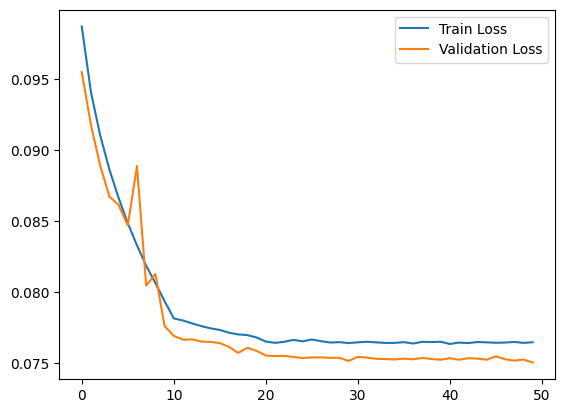

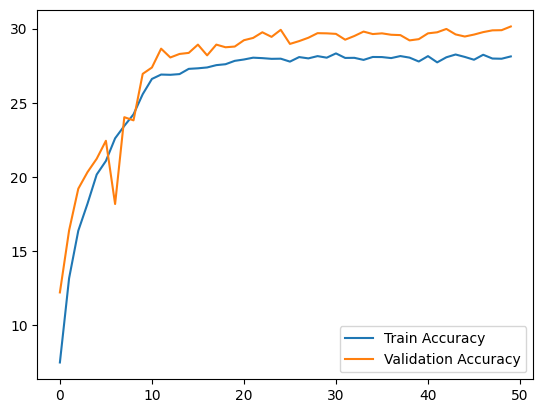

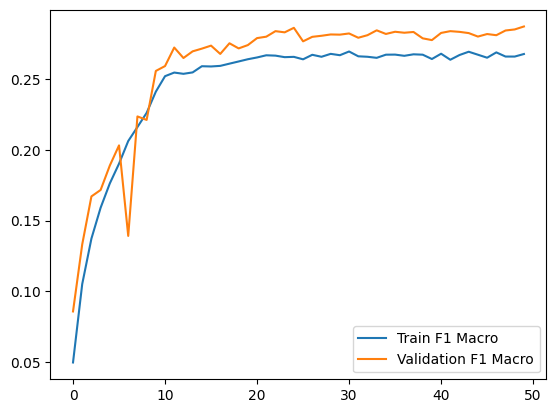

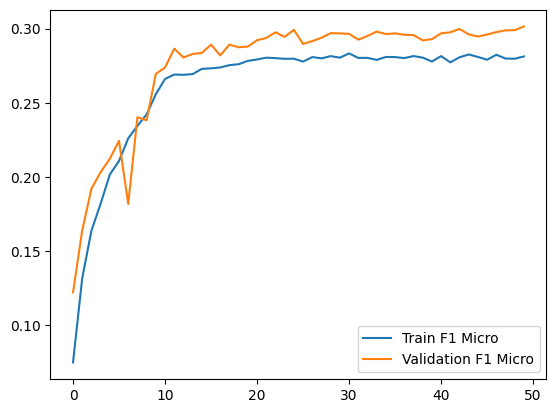

In [5]:
# Plot the error, accuracy and F1 (both macro and micro) curves for
# both train and val data

def plot_curves():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))
   

    net = final_resnet(3, r, n)

    net = net.to(device)
    print("Working on device: ", device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()
    plt.show()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

plot_curves()
